In [13]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pyproj

In [14]:
# gw100m
answer_location = (52.53962045830213, 13.419884901364885, 100)
source_locations = [(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.54124707715658, 13.42007143605056, 23), (52.53863682156572, 13.423243543905807, 5.1), (52.54022829654233, 13.424028618727982, 23), (52.53768690920158, 13.423827698593255, 19), (52.53701243697258, 13.41926365424317, 23), (52.53765506974833, 13.416535624425991, 23), (52.540951204354315, 13.414768595630743, 19), (52.53846109447526, 13.42080118586715, 23)]
rssi = np.array([-71.63403554811134, -69.09353142802274, -73.94630524200359, -67.04524365136507, -69.38046352414914, -63.81425676768592, -65.51133843649967, -71.99102431036357, -69.9814290434943, -70.69053819851595])
d = []
for i in range(len(rssi)):
    d.append(10**((-18.67881 - rssi[i]) / (10 * 2.04002)))
print(d)

# # gw100m_nobuilding
# answer_location = (52.53962045830213, 13.419884901364885, 200)
# source_locations = [(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.54124707715658, 13.42007143605056, 23), (52.53863682156572, 13.423243543905807, 5.1), (52.54022829654233, 13.424028618727982, 23), (52.53768690920158, 13.423827698593255, 19), (52.53701243697258, 13.41926365424317, 23), (52.53765506974833, 13.416535624425991, 23), (52.540951204354315, 13.414768595630743, 19), (52.53846109447526, 13.42080118586715, 23)]
# rssi = np.array([-71.33057463016215, -69.47921756875596, -73.58976692127023, -66.84978429622257, -69.3463866455216, -63.86118311152556, -65.43775615882458, -68.51723739248007, -69.74188545126587, -70.67158737502467])
# d = []
# for i in range(len(rssi)):
#     d.append(10**((-18.67881 - rssi[i]) / (10 * 2.04002)))
# print(d)

[394.29288508294167, 295.9958660450461, 511.8755465287958, 234.89856649485617, 305.73897592295174, 163.11736949587115, 197.555748566392, 410.50477950801775, 327.19722509936946, 354.46186954189903]


[[ 393206.92929944 5822545.57797782]
 [ 392648.90380971 5822105.97886155]
 [ 392853.52073335 5822412.81237481]
 [ 393062.2869512  5822117.78918582]
 [ 393119.39393133 5822293.63344594]
 [ 393099.59493713 5822011.27248963]
 [ 392788.42587066 5821943.02651801]
 [ 392604.98099848 5822018.55750819]
 [ 392493.19731635 5822387.79122519]
 [ 392896.22615985 5822101.86626953]]
[ 596768.90198158 4433720.53683546]
[88.23750734046618, 76.28838260771381, 100.68520710896857, 67.80834262756409, 77.55500962838595, 56.23475251050212, 62.05735227455193, 90.0560691467285, 80.27418328446198, 83.60165901965092]
Receiver location: [52.53933372738674, 13.420482812867087]
[390.15033646 169.97307806 113.99378215 134.873598   182.7379781
 235.39123468 209.10226164 236.38785222 347.0582869   15.85075409]


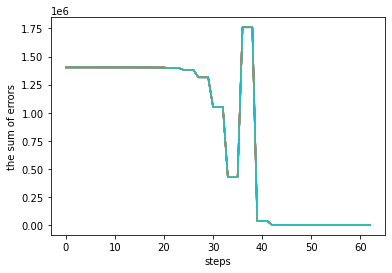

In [15]:
# multilateration program

errors_array = []

R = 6371000 # radius of the earth in meters

# GPS coordinates of the sources
# source_locations = [
#     (46.048174, 11.134445, 0),  # Source 1
#     (46.048275, 11.134562, 0),  # Source 2
#     (46.048389, 11.134393, 0),  # Source 3
#     (46.048431, 11.134557, 0)  # Source 4
# ]

altitude = 10
zone = int((source_locations[0][1] + 180) / 6) + 1

# Distances from the receiver to the sources
# d = np.array([7.5, 7.2, 9.8, 9.4])

# Convert GPS coordinates to Cartesian coordinates
# def to_cartesian(lat, lon, alt):
#     x, y, z = pyproj.Transformer.from_crs(4979, 4978, always_xy=True).transform(lon, lat, alt)
#     return x, y, z

def to_cartesian(lat, lon):
    # Calculate UTM zone from longitude
    zone = int((lon + 180) / 6) + 1
    # Determine if the point is in the Northern or Southern hemisphere
    hemisphere = 'north' if lat >= 0 else 'south'

    # define the coordinate systems
    transformer = pyproj.Transformer.from_crs("epsg:4326", f"epsg:326{zone if lat >= 0 else zone + 100}")

    x, y = transformer.transform(lat, lon)
    return x, y

# Convert Cartesian coordinates to GPS coordinates
# def to_gps(x, y, z):
#     lon, lat, alt = pyproj.Transformer.from_crs(4978,4979, always_xy=True).transform(x, y, z)
#     return lat, lon, alt

def to_gps(x, y, zone, hemisphere):
    # define the coordinate systems
    transformer = pyproj.Transformer.from_crs(f"epsg:326{zone if hemisphere == 'north' else zone + 100}", "epsg:4326")
    
    lat, lon = transformer.transform(x, y)
    return [lat, lon]

# Calculate the distance between the receiver and each source
def distance(xy_receiver, xy_source):
    return np.linalg.norm(xy_source - xy_receiver)

# Objective function to minimize the sum of squared errors between estimated and actual distances
def error(xy_receiver, xy_sources, d):
    distances = np.linalg.norm(xy_sources - xy_receiver, axis=1)
    errors = distances - d
    errors_array.append(np.sqrt(errors**2))
    return np.sum(errors**2)

# Define a function to convert radians to degrees
def degrees(rad):
    return rad * 180 / np.pi

# Starting GPS coordinates of the receiver (can be anywhere)
receiver_location = (40.048174, 10.134445, 0)

# Convert the GPS coordinates of the sources and the receiver to Cartesian coordinates
xy_sources = np.array([to_cartesian(lon, lat) for lon, lat, _ in source_locations])
xy_receiver = np.array(to_cartesian(*receiver_location[:2]))

print(xy_sources)
print(xy_receiver)

# Calculate the distance in 2d plane at the altitude
d_2d = []
for i in range(len(d)):
    alt_diff = np.abs(altitude - d[i])
    distance_2d = np.sqrt(d[i]**2-alt_diff**2)
    d_2d.append(distance_2d)
print(d_2d)

# Perform multilateration to estimate the location of the receiver
result = minimize(error, xy_receiver, args=(xy_sources, d_2d))
xy_receiver_estimated = result.x

# Convert the estimated Cartesian coordinates of the receiver back to GPS coordinates
receiver_location_estimated = to_gps(*xy_receiver_estimated, zone, 'north')

print('Receiver location:', receiver_location_estimated)


# # Plot the sources and the estimated location of the receiver
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Plot the sources
# for i in range(len(source_locations)):
#     x, y, z = to_cartesian(*source_locations[i])
#     ax.scatter(x, y, z, color='r', marker='^')

# # Plot the estimated location of the receiver
# x, y, z = to_cartesian(*receiver_location_estimated)
# ax.scatter(x, y, z, color='b', marker='o')

# # Set the labels and title
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('Multilateration')

# print(source_locations)
# # Plot circles (or spheres) representing the distance from each source
# for i in range(len(source_locations)):
#     # Calculate the radius of the circle (or sphere) in meters
#     radius = d[i]
#     # Get the Cartesian coordinates of the source
#     x, y, z = to_cartesian(*source_locations[i])
#     # Create a grid of points on the surface of the sphere
#     # Sphere in 3D
#     u = np.linspace(0, 2*np.pi, 100)
#     v = np.linspace(0, np.pi, 100)
#     X = x + radius*np.outer(np.cos(u), np.sin(v))
#     Y = y + radius*np.outer(np.sin(u), np.sin(v))
#     Z = z + radius*np.outer(np.ones_like(u), np.cos(v))
#     ax.plot_surface(X, Y, Z, color='r', alpha=0.2)

# plt.show()

# create a figure for error
fig = plt.figure()

plt.plot(errors_array)
plt.xlabel("steps")
plt.ylabel("the sum of errors")
print(errors_array[-1])

# show the plot
plt.show()

import folium

# Plot the sources and the estimated location of the receiver on a 2D map
m = folium.Map(location=receiver_location_estimated[:2], zoom_start=18, max_zoom=20)

# Plot the sources
for i in range(len(source_locations)):
    folium.Marker(location=source_locations[i][:2]).add_to(m)

# Plot the estimated location of the receiver
folium.Marker(location=receiver_location_estimated[:2], icon=folium.Icon(color='purple')).add_to(m)

# answer
folium.Marker(location=answer_location[:2], icon=folium.Icon(color='green')).add_to(m)

# Plot circles representing the distance from each source
for i in range(len(source_locations)):
    # Calculate the radius of the circle in meters
    radius = d[i]
    # Get the location of the source
    source_location = source_locations[i][:2]
    # Draw the circle on the map
    folium.Circle(location=source_location, radius=radius, color='red', fill=False).add_to(m)

m



In [16]:
# create every pattern of 4 or more beacons
import itertools

source_locations_iter = []
d_iter = []
for n in range(3,len(source_locations)+1):
	for source_location in itertools.combinations(source_locations, n):
	    source_locations_iter.append(list(source_location))
	    
for n in range(3,len(d_2d)+1):
	for d_i in itertools.combinations(d_2d, n):
	    d_iter.append(list(d_i))
print(source_locations_iter)
print(d_iter)

[[(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.54124707715658, 13.42007143605056, 23)], [(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.53863682156572, 13.423243543905807, 5.1)], [(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.54022829654233, 13.424028618727982, 23)], [(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.53768690920158, 13.423827698593255, 19)], [(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.53701243697258, 13.41926365424317, 23)], [(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.53765506974833, 13.416535624425991, 23)], [(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.540951204354315, 13.414768595630743, 19)], [(52.542509627168, 13.42523777393717, 23), (52.5384493

[[184.75160370009954, 125.54656007916195, 3, 124.7572593105535], [222.85988911020135, 130.66845825476844, 3, 80.60930569372978], [208.61705787442634, 151.71381880583348, 3, 95.99455778320672], [255.66192110040677, 146.89875711267817, 3, 52.00820642757829], [260.70544865811615, 61.81821781815811, 3, 81.87571424259197], [259.78256478045324, 8.238708880645188, 3, 96.57164381848536], [267.07084277649, 127.30171108614344, 3, 69.96979974149353], [212.71783916260333, 93.8310408280573, 3, 91.99233627340818], [144.7394983811458, 245.93675920458026, 3, 24.458457371032026], [91.40637570095332, 294.2388605222405, 3, 18.33265504001473], [189.68673570978567, 239.34712596313304, 3, 39.04545807579367], [222.0990506496133, 128.35986654117679, 3, 102.93739600472007], [215.60714222265906, 90.07131007046398, 3, 135.1705062306599], [197.33362943616612, 252.05379087942418, 3, 119.3098832547274], [148.6206790460818, 203.7242872813373, 3, 57.58895556879847], [108.89736394003778, 318.9601483093755, 3, 56.42352

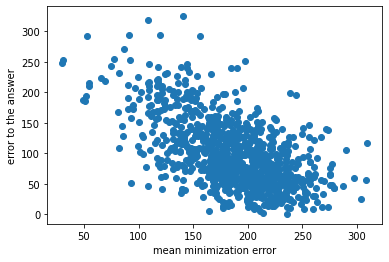

In [17]:
# multilateration with every patterns

errors_array = []

R = 6371000 # radius of the earth in meters

# GPS coordinates of the sources
# source_locations = [
#     (46.048174, 11.134445, 0),  # Source 1
#     (46.048275, 11.134562, 0),  # Source 2
#     (46.048389, 11.134393, 0),  # Source 3
#     (46.048431, 11.134557, 0)  # Source 4
# ]

altitude = 10
zone = int((source_locations[0][1] + 180) / 6) + 1

# Distances from the receiver to the sources
# d = np.array([7.5, 7.2, 9.8, 9.4])

# Convert GPS coordinates to Cartesian coordinates
# def to_cartesian(lat, lon, alt):
#     x, y, z = pyproj.Transformer.from_crs(4979, 4978, always_xy=True).transform(lon, lat, alt)
#     return x, y, z

def to_cartesian(lat, lon):
    # Calculate UTM zone from longitude
    zone = int((lon + 180) / 6) + 1
    # Determine if the point is in the Northern or Southern hemisphere
    hemisphere = 'north' if lat >= 0 else 'south'

    # define the coordinate systems
    transformer = pyproj.Transformer.from_crs("epsg:4326", f"epsg:326{zone if lat >= 0 else zone + 100}")

    x, y = transformer.transform(lat, lon)
    return x, y

# Convert Cartesian coordinates to GPS coordinates
# def to_gps(x, y, z):
#     lon, lat, alt = pyproj.Transformer.from_crs(4978,4979, always_xy=True).transform(x, y, z)
#     return lat, lon, alt

def to_gps(x, y, zone, hemisphere):
    # define the coordinate systems
    transformer = pyproj.Transformer.from_crs(f"epsg:326{zone if hemisphere == 'north' else zone + 100}", "epsg:4326")
    
    lat, lon = transformer.transform(x, y)
    return [lat, lon]

# Calculate the distance between the receiver and each source
def distance(xy_receiver, xy_source):
    return np.linalg.norm(xy_source - xy_receiver)

# Objective function to minimize the sum of squared errors between estimated and actual distances
def error(xy_receiver, xy_sources, d):
    distances = np.linalg.norm(xy_sources - xy_receiver, axis=1)
    errors = distances - d
    errors_array.append(np.sqrt(errors**2))
    return np.sum(errors**2)

# Define a function to convert radians to degrees
def degrees(rad):
    return rad * 180 / np.pi

xy_receiver_estimated_list = []
receiver_locations_estimated = []
error_answer_minimization = []

for i in range(len(d_iter)):

    source_locations = source_locations_iter[i]
    distance = d_iter[i]

    # Starting GPS coordinates of the receiver (can be anywhere)
    receiver_location = (40.048174, 10.134445, 0)

    # Convert the GPS coordinates of the sources and the receiver to Cartesian coordinates
    xy_sources = np.array([to_cartesian(lon, lat) for lon, lat, _ in source_locations])
    xy_receiver = np.array(to_cartesian(*receiver_location[:2]))

    # Perform multilateration to estimate the location of the receiver
    result = minimize(error, xy_receiver, args=(xy_sources, distance))
    xy_receiver_estimated = result.x
    xy_receiver_estimated_list.append(xy_receiver_estimated)

    error_answer = np.linalg.norm(to_cartesian(*answer_location[:2])-xy_receiver_estimated)
    error_answer_minimization.append([np.mean(errors_array[-1]), error_answer, len(distance), np.std(errors_array[-1])])

    # Convert the estimated Cartesian coordinates of the receiver back to GPS coordinates
    receiver_location_estimated = to_gps(*xy_receiver_estimated, zone, 'north')
    receiver_locations_estimated.append(receiver_location_estimated)

    # print('Receiver location:', xyz_receiver_estimated)
    # print('Receiver location:', receiver_location_estimated)
    # print('error', np.sum(errors_array[-1]))

print(error_answer_minimization)
error_answer_minimization.sort(key=lambda item: item[0])
plt.scatter([item[0] for item in error_answer_minimization], [item[1] for item in error_answer_minimization])
plt.xlabel("mean minimization error")
plt.ylabel("error to the answer")
plt.show()

import folium

# Plot the sources and the estimated location of the receiver on a 2D map
m = folium.Map(location=receiver_location_estimated[:2], zoom_start=18, max_zoom=20)

# Plot the sources
for i in range(len(source_locations)):
    folium.Marker(location=source_locations[i][:2]).add_to(m)

for i in range(len(receiver_locations_estimated)):
# Plot the estimated location of the receiver
    folium.Marker(location=receiver_locations_estimated[i][:2], icon=folium.Icon(color='purple'), tooltip=f'Point {i}').add_to(m)

# answer
folium.Marker(location=answer_location[:2], icon=folium.Icon(color='green')).add_to(m)

# Plot circles representing the distance from each source
for i in range(len(source_locations)):
    # Calculate the radius of the circle in meters
    radius = d[i]
    # Get the location of the source
    source_location = source_locations[i][:2]
    # Draw the circle on the map
    folium.Circle(location=source_location, radius=radius, color='red', fill=False).add_to(m)

m



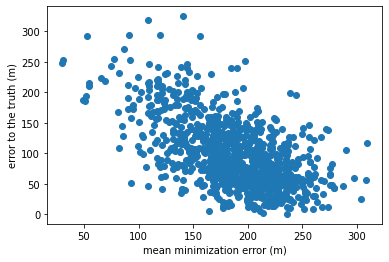

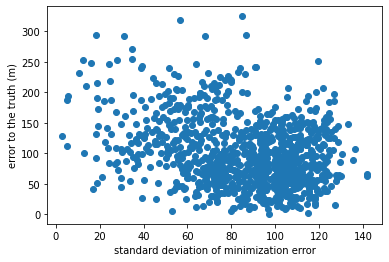

[]
[[209.86882709102585, 218.87797123189404, 243.60749827371018, 144.44311896870573, 191.13590008371483, 172.196111193499, 158.64508761355785, 179.62413091627516, 206.7587007070477, 224.54005963731004, 188.37753282620102, 151.16409260708318, 102.03258854081552, 99.07026276685696, 46.40930799772072, 215.41662098733403, 192.89647990122137, 211.22888487683622, 177.3122086372296, 246.7507933272515, 105.58136864734983, 179.49919038265642, 135.31463122026128, 166.35472755735674, 221.00604790024488, 209.83317804335218, 93.29632191852097, 121.59803591985033, 188.12108219451477, 222.478346539019, 294.55430405658143, 204.9269846014223, 41.20663894393888, 210.77403970430584, 62.360684687117555, 186.97679990041834, 89.71625802673674, 150.71964045063004, 85.07059993938758, 123.28383350098666, 196.53115718017582, 110.94331473334341, 104.70106623396002, 150.12136783032025, 78.15664822571574, 214.5937016313971, 159.59114139234532, 133.3601962445058, 240.8976930722103, 35.258938117974985, 143.819084886

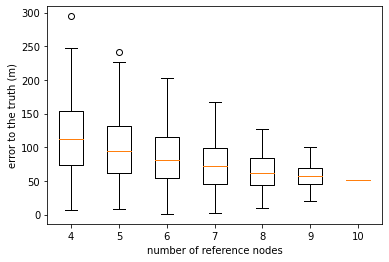

[]
[[54.36679105933245, 69.61822657264533, 74.83468827121509, 84.9579873808658, 90.49180040927475, 90.58590119632134, 93.13526805873899, 94.6635290064261, 96.60938403609204, 99.93645544115208, 100.11328105982935, 100.6817737374094, 101.67061996683128, 103.8768832547901, 108.25716957518787, 108.78430896935384, 109.06392761619068, 109.61925128008068, 109.83933978623556, 109.99792200019844, 110.78876702112905, 111.61913230177605, 111.89657030982809, 112.01595914264243, 116.46839024255328, 116.70243613783578, 116.98726950730162, 117.14627880201718, 117.35371164546606, 117.4748583400994, 119.41410659404269, 121.15359482055672, 121.37852755572573, 121.86284393630712, 123.78375770157987, 124.2321779139246, 125.89193849355506, 127.63430785638363, 130.5941623601479, 131.8579122955916, 131.90272217328442, 132.00349500162525, 133.04082847766097, 133.52573819019705, 134.77775999628577, 136.2188229426951, 137.055164896971, 138.36263664294924, 138.50299994419777, 138.70629855107023, 138.765019003289

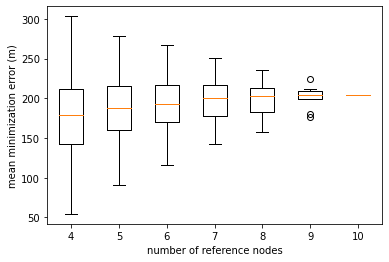

In [18]:
# visualization of multilateration with every pattern
# the relation between error to the truth and mean minimization error, number of reference nodes
error_answer_minimization.sort(key=lambda item: item[0])
plt.figure(facecolor="white")
plt.scatter([item[0] for item in error_answer_minimization], [item[1] for item in error_answer_minimization])
plt.xlabel("mean minimization error (m)")
plt.ylabel("error to the truth (m)")

#find line of best fit
a, b = np.polyfit([item[0] for item in error_answer_minimization], [item[1] for item in error_answer_minimization], 1)

#add line of best fit to plot
# plt.plot(np.array([item[0] for item in error_answer_minimization]), a*np.array([item[0] for item in error_answer_minimization])+b)    
plt.show()

error_answer_minimization.sort(key=lambda item: item[0])
plt.figure(facecolor="white")
plt.scatter([item[3] for item in error_answer_minimization], [item[1] for item in error_answer_minimization])
plt.xlabel("standard deviation of minimization error")
plt.ylabel("error to the truth (m)")

#find line of best fit
a, b = np.polyfit([item[3] for item in error_answer_minimization], [item[1] for item in error_answer_minimization], 1)

#add line of best fit to plot
# plt.plot(np.array([item[0] for item in error_answer_minimization]), a*np.array([item[0] for item in error_answer_minimization])+b)    
plt.show()

plt.figure(facecolor="white")
error_answer_reference_boxplot = [[] for _ in range(20)]
print(error_answer_reference_boxplot[0])

for i in range(len(error_answer_minimization)):
    error_answer_reference_boxplot[error_answer_minimization[i][2]-4].append(error_answer_minimization[i][1])
print(error_answer_reference_boxplot)
plt.boxplot(error_answer_reference_boxplot[:7])
plt.xticks([i for i in range(1,8)],[i for i in range(4,11)])
plt.xlabel("number of reference nodes")
plt.ylabel("error to the truth (m)")
plt.show()

plt.figure(facecolor="white")
error_answer_reference_boxplot = [[] for _ in range(20)]
print(error_answer_reference_boxplot[0])

for i in range(len(error_answer_minimization)):
    error_answer_reference_boxplot[error_answer_minimization[i][2]-4].append(error_answer_minimization[i][0])
print(error_answer_reference_boxplot)
plt.boxplot(error_answer_reference_boxplot[:7])
plt.xticks([i for i in range(1,8)],[i for i in range(4,11)])
plt.xlabel("number of reference nodes")
plt.ylabel("mean minimization error (m)")
plt.show()

In [19]:
# multilateration with provided altitude of the drone
